# 1B. Solution: Swingup Problem with Small Angle Assumption

In this section the complexity of dynamic constraints are increased in an attempt to obtain a more acurate solution to the swing up problem. The small angle assumtion is still made to simplify the model. However, the effect of centripital acceleration on the optimimization is included.

Small Angle Asumption:
$$ cos(q_2) \approx 1 $$
$$ sin(q_2) \approx q_2 $$

Centripital Acceleration:
$$ \alpha = lm_2\dot q_2^2 $$

This simplification removes the trigonometric functions from the dynamic constraints and is usually considered valid for angles of less than 10 degrees about the angle of linearization.

The simplified dynamic constraints for the optimization are:
$$ \ddot q_1 = \frac{lm_2sin(q_2)\dot q_2^2 + u + m_2gcos(q_2)sin(q_2)}{m_1 + m_2(1-cos^2(q_2))} \approx \frac{lm_2q_2\dot q_2^2 + u + m_2gq_2}{m_1} $$
$$ \ddot q_2 = - \frac{lm_2cos(q_2)sin(q_2)\dot q_2^2 + ucos(q_2) + (m_1+m_2)gsin(q_2)}{lm_1 + lm_2(1-cos^2(q_2))} \approx - \frac{lm_2q_2\dot q_2^2 + u + (m_1+m_2)gq_2}{lm_1} $$

Both sets of constraints are non-linear and are not able to be expressed in a quadratic or second order cone form becasue of centripital acceleration terms, $lm_2q_2\dot q_2^2$, in each of the equations. This forces us to approach the optimization problem with a non linear solver like "Ipopt".

In [8]:
using JuMP, Ipopt

#define initial and final states, x
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 


"""
linearize the dynamics of the cart pull mechanism through the small angle assumption -> first term
in taylor series expansion for sin(q) and cos(q)

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvNonStaticCartPull(x0, xf, tf, h, itype = "forwardEuler")
    
    #define model
    #m = Model(solver = GurobiSolver(OutputFlag=0))
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                    #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)
    
    #dynamics (path) constraints, integral form

    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])
        @constraint(m,xdot[2,k] == x[4,k]) 
        @NLconstraint(m,xdot[3,k] == (l*m2*x[2,k]*x[4,k]^2 + u[1,k] + m2*g*1*x[2,k]) / m1)
        @NLconstraint(m,xdot[4,k] == (-l*m2*1*x[2,k]*x[4,k]^2 + u[1,k]*1 + (m1 + m2)*g*x[2,k]) / l*m1) 

    end
    
    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "backwardEuler"
        #add backwards euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2) ) #+ sum(x[2,:]).^2))
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    # Transform to x and y coordinates of the mass location
    xCordM = zeros(1,K)
    yCordM = zeros(1,K)
    xCordM = xopt[1,:] + l*cos.(xopt[2,:] + (pi/2))
    yCordM = -l*sin.(xopt[2,:] + (pi/2))
    
    # Transform to x and y coordinates of the cartb
    xCordC = zeros(1,K)
    yCordC = zeros(1,K)
    xCordC = xopt[1,:]'
    
    return (control, xopt, xdotopt, xCordM, yCordM , xCordC, yCordC)
end

SolvNonStaticCartPull

# Solution: Swingup With Small Angle Assumption

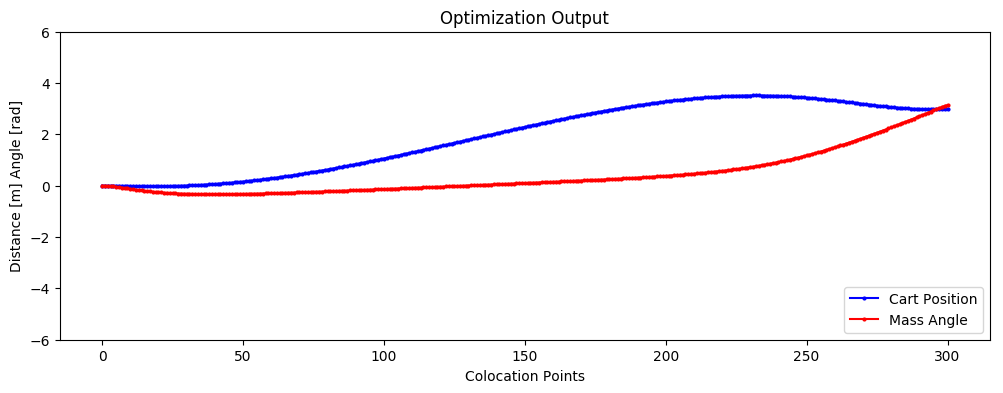

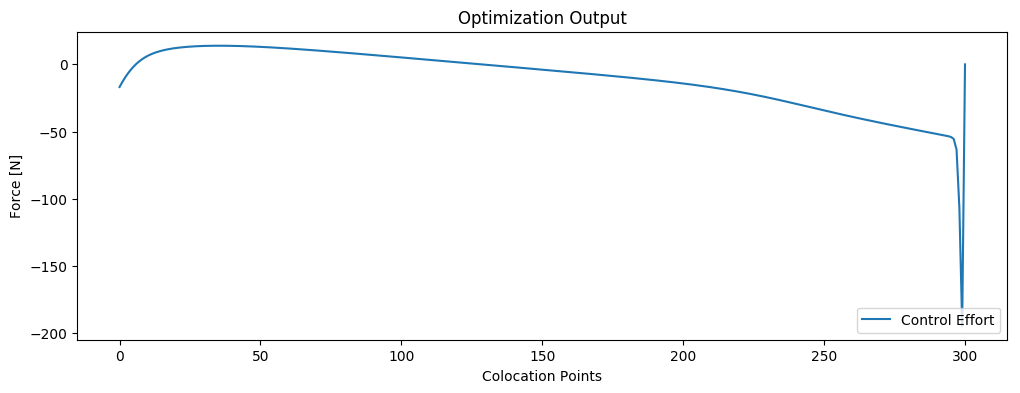

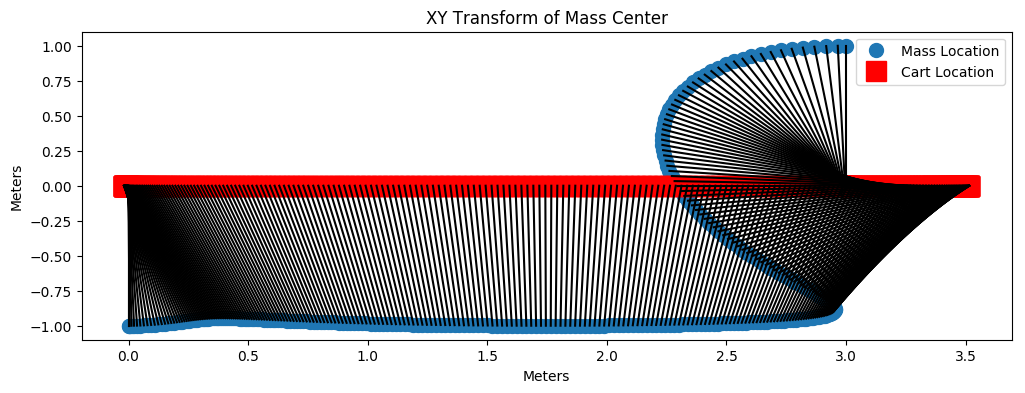

In [9]:
(c, x, xdot, xCordM, yCordM, xCordC, yCordC) = SolvNonStaticCartPull(x0,xf,3,.01)

using PyPlot
figure(figsize=(12,4))
title("Optimization Output")
xlabel("Colocation Points")
ylabel("Distance [m] Angle [rad]")
plot( x[1,:], "b.-", markersize = 4)
plot( x[2,:], "r.-", markersize = 4)
ylim([-6,6])
legend(["Cart Position","Mass Angle"], loc="lower right")

figure(figsize=(12,4))
title("Optimization Output")
xlabel("Colocation Points")
ylabel("Force [N]")
plot(c[1,:])
legend(["Control Effort"], loc="lower right")

figure(figsize=(12,4))
title("XY Transform of Mass Center")
xlabel("Meters")
ylabel("Meters")
plot( xCordM, yCordM,".", markersize = 20)
plot( xCordC, yCordC,"rs", markersize = 15)
legend(["Mass Location","Cart Location"], loc="Top right")
for i =1:length(xCordM)
 plot( [xCordM[i],xCordC[i]] , [yCordM[i], yCordC[i]],"k")
end
ylim([-1.1,1.1]);

# Placeholder For a Gif of the Solution

# Results and Discussion: Swingup Problem with Small Angle Assumption

The small angle assumption simplifies the constraints on the optimization. However becasue the assumption linearizes the solution about a certain angle we see unatural behaviour from the pendulum as it travels beyond the limititations of the assumption during swing up. 

# 2.A Avoiding Obsticals With Soft Constraints

It is easy to concieve a situation where obstical avoidance would be necesary in the swing up problem. One approach to obstical avoidance is to include a soft constraint in the form of a regulizar in the objective function. 

$$ z = \sqrt{((x-x_off)^2 + (y-y_off)^2)} $$

A plot visualizing the function used in this section is shown below:

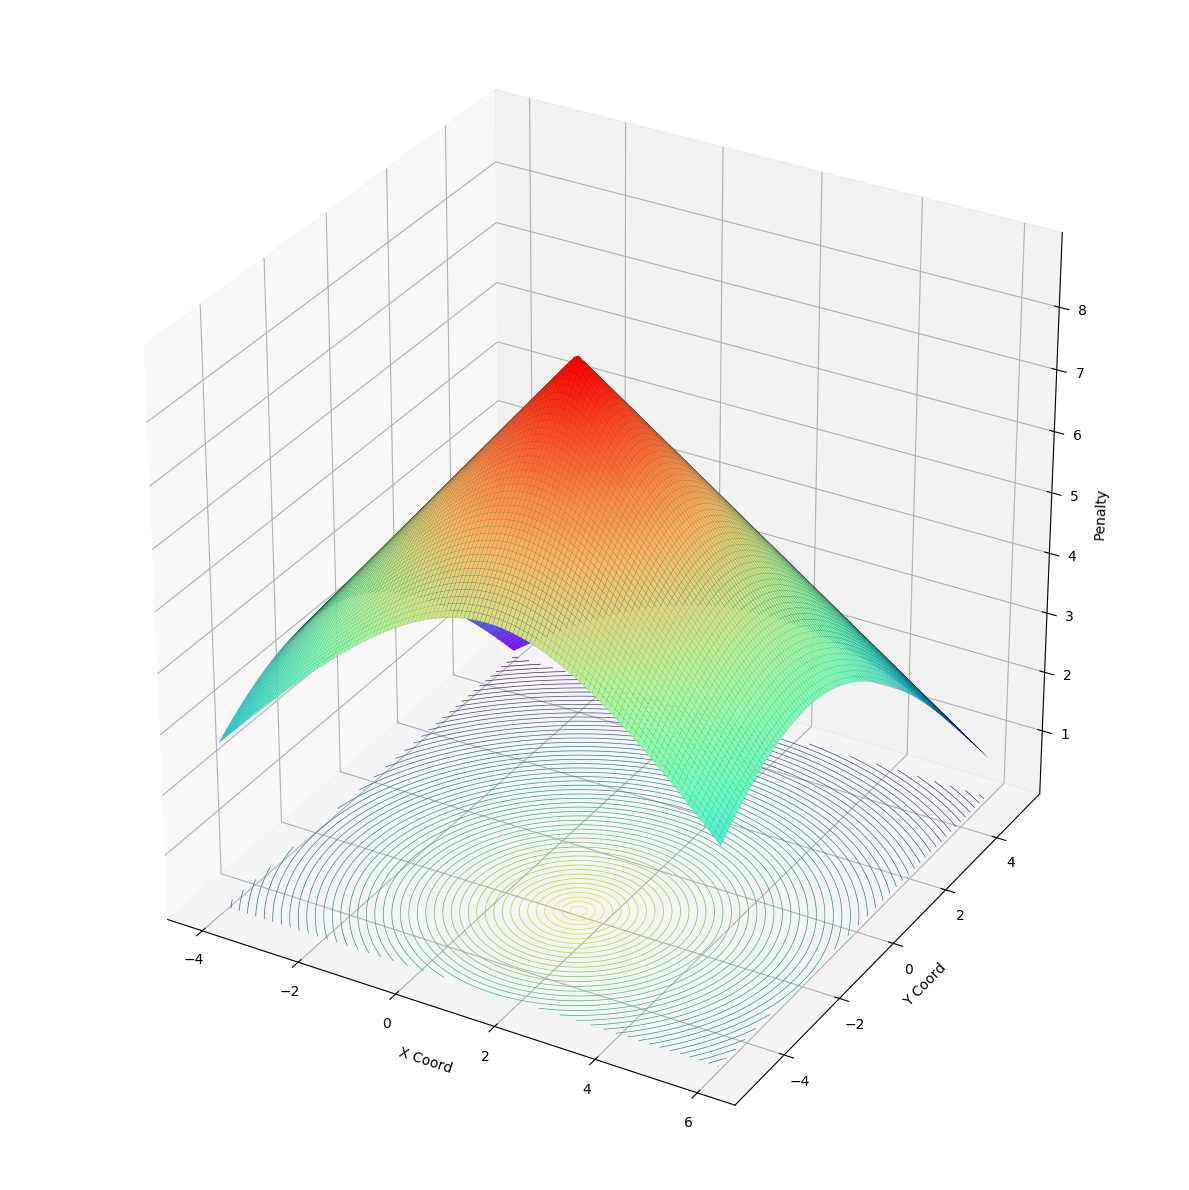

In [69]:
xv = linspace(-4,6,1000)
yv = linspace(-5,5,1000)
xoff = 1.5
yoff = -2

# swap x and y to obtain standard coordinates
z = [ -((x-xoff)^2+(y-yoff)^2)^(1/2)+9 for y in yv, x in xv ];

function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repmat(vx, m, 1), repmat(vy, 1, n))
end
(X,Y) = meshgrid(xv,yv);

pygui(false)
figure(figsize=(12,12))
surf(X,Y, z, rstride=8, cstride=8,cmap="rainbow",edgecolor="black", linewidths=.05)
contour(X, Y, z, zdir="z", 60, offset=0, origin="lower", linewidths=.5 )
xlabel("X Coord"); ylabel("Y Coord"); zlabel("Penalty");
tight_layout()

The function penalizes the objective function centered at the point $ (x_off,y_off) $ and promotes a solutions further away from the object. With the regulizer included and in terms of $q_1$ and $q_2$ the objective function takes the form of the following equation.

$$ \sum(u^2) + \lambda \sum \sqrt{(q_1 + lcos(q_2+ \frac{\pi}{2}) - x_off)^2 + (-lsin(q2+ \frac{\pi}{2}) - y_off)^2} $$

In [137]:
using JuMP, PyPlot, Ipopt

#define initial and final states, x
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 

"""
solve the cart pull problem using direct collocation and full dynamics

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvRegularizedCartPull(x0, xf, tf, h, xoff, yoff, y, itype = "backwardEuler")
    
    #define model
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)

    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])                      #this step could be wrong!!! I may need to integrate here
        @constraint(m,xdot[2,k] == x[4,k])                      #look here for an issue
         #calculate xdot    
        q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
        @NLconstraint(m,xdot[3,k] ==  (l*m2*sin(q2)*q2dot^2 + u[1,k] + m2*g*cos(q2)*sin(q2)) /
                                    (m1 + m2*(1-cos(q2)^2)))
        @NLconstraint(m,xdot[4,k] == -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u[1,k]*cos(q2) + (m1 + m2)*g*sin(q2))/
                                    (l*m1 + l*m2*(1-cos(q2)^2)))

    end
    

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "backwardEuler"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @NLexpression(m, reg[1,i=1:K], -(((x[1,i] + l*cos(x[2,i] + pi/2) - xoff))^2 + (-l*sin(x[2,i] + pi/2) + yoff)^2 )^(1/2) ) 
    @NLobjective(m, Min, sum(u[j]^2 + y*reg[1,j] for j=1:K) ) 
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    # Transform to x and y coordinates of the tip location
    xCordM = zeros(1,K)
    yCordM = zeros(1,K)
    xCordM = xopt[1,:] + l*cos.(xopt[2,:] + (pi/2))
    yCordM = -l*sin.(xopt[2,:] + (pi/2))
    
    # Transform to x and y coordinates of the Cart
    xCordC = zeros(1,K)
    yCordC = zeros(1,K)
    xCordC = xopt[1,:]'
    
    return (m, control, xopt, xdotopt, xCordM, yCordM , xCordC, yCordC)
end

SolvRegularizedCartPull

# Solution: Avoiding Obsticals with Soft Constraints

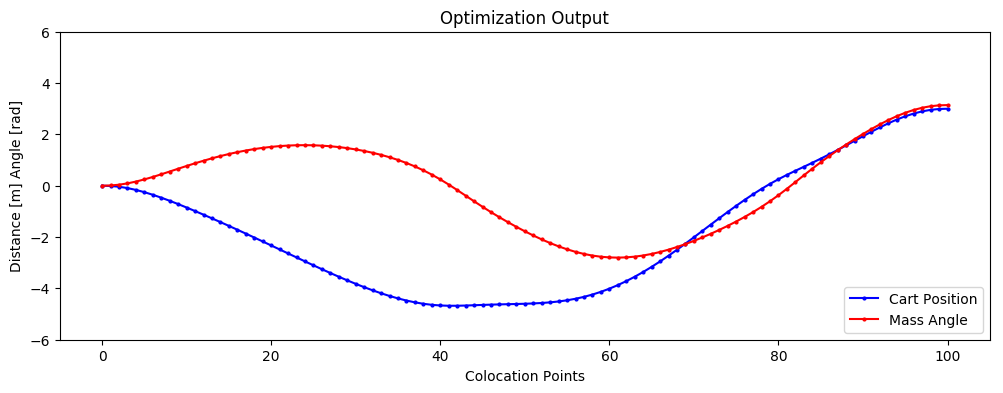

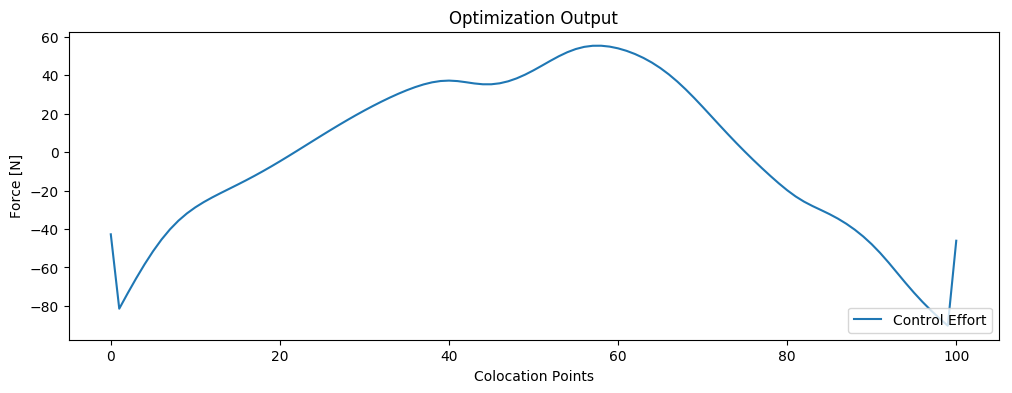

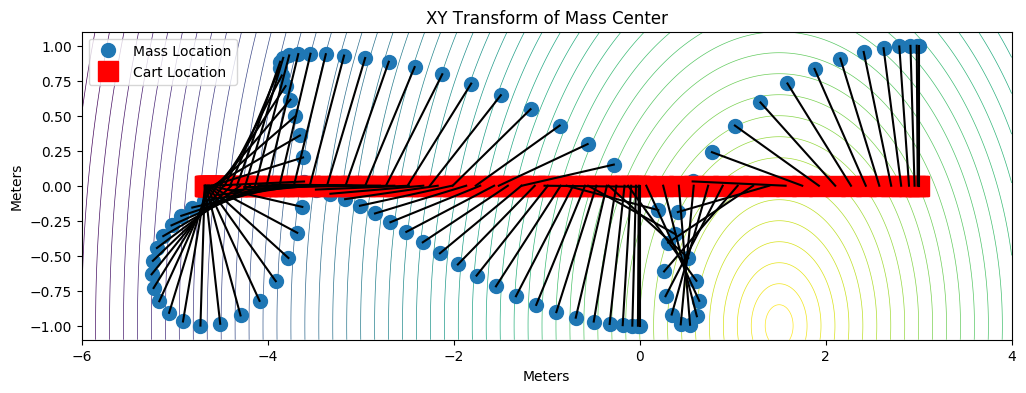

In [138]:
# 
y = 1000
xoff = 1.5
yoff = -1

(m, c, x, xdot, xCordM, yCordM, xCordC, yCordC) = SolvRegularizedCartPull( x0, xf, 3, .03, xoff, yoff, y)

using PyPlot
figure(figsize=(12,4))
title("Optimization Output")
xlabel("Colocation Points")
ylabel("Distance [m] Angle [rad]")
plot( x[1,:], "b.-", markersize = 4)
plot( x[2,:], "r.-", markersize = 4)
ylim([-6,6])
legend(["Cart Position","Mass Angle"], loc="lower right")

figure(figsize=(12,4))
title("Optimization Output")
xlabel("Colocation Points")
ylabel("Force [N]")
plot(c[1,:])
legend(["Control Effort"], loc="lower right")

figure(figsize=(12,4))
title("XY Transform of Mass Center")
xlabel("Meters")
ylabel("Meters")
plot( xCordM, yCordM,".", markersize = 20)
plot( xCordC, yCordC,"rs", markersize = 15)
legend(["Mass Location","Cart Location"])
for i =1:length(xCordM)
 plot( [xCordM[i],xCordC[i]] , [yCordM[i], yCordC[i]],"k")
end

xv = linspace(-6,4,1000)
yv = linspace(-1.1,1.1,1000)
function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repmat(vx, m, 1), repmat(vy, 1, n))
end
(X,Y) = meshgrid(xv,yv);

z = [ -((x-xoff)^2+(y-yoff)^2)^(1/2)+9 for y in yv, x in xv ];
contour(X, Y, z, zdir="z", 60, offset=0, linewidths=.5 )
xlim([-6,4]);
ylim([-1.1,1.1]);

# Placeholder for a GIF of the Solution

Adjusting lambda allows the optimezer to find a solution that avoids the object placed at $(x_off,y_off) $. A different and possibly more effective solution for obstical avoidance using soft constraints might be obtained by using a different cost function. A cone cost function like the one used in this optimization penalizes the optimizer linearly with distance from the object. Another function that does not penalize the objective function in free space might prove to be a more effecticve regularizing function for obstical avoidance. 

# 2.B Avoiding Obsticals With Explicit Constraints

Another approach to obstical avoidance is to use explicit constraints, insted of penalizing the objective function with a vector field. The aproach constraints the solution to a space outside an ellipse which is placed around the object. The quadratic constraint is implemented for each of the colocation points constraining the mass of the pendulum from entering the designated area at any point in time.

The form of the constraint implemented at each colocation point is:

$$ \frac{(q_1 + lcos(q_2 + \frac{\pi}{2}) + x_off)^2}{a^2} + \frac{(-lsin(q_2 + \frac{\pi}{2}) + y_off)^2}{b^2} >= 1 $$

# Solution: Avoiding Obsticals With Explicit Constraints

The explicit constraint for obstical avoidance is a quadratic constraint. Consequently, the @NLconstraint function must be used to implement objecct avoidance in this way. This could be considered a negative aspect of this implementation of object avoidance. 

In [92]:
using JuMP, PyPlot, Ipopt

#define initial and final states, x
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 

"""
solve the cart pull problem using direct collocation and full dynamics

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvFullCartPullObstical(x0, xf, tf, h, a, b, c, xoff, yoff, itype = "backwardEuler")
    
    #define model
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)

    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    
        # Elypse constraint on the mass location
    for i = 1:K
        @NLconstraint(m, ((x[1,i] + l*cos(x[2,i] + pi/2)) - xoff)^2/a^2 + ((-l*sin(x[2,i] + pi/2)) - yoff)^2/b^2 >= c )
    end
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])                      #this step could be wrong!!! I may need to integrate here
        @constraint(m,xdot[2,k] == x[4,k])                      #look here for an issue
         #calculate xdot    
        q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
        @NLconstraint(m,xdot[3,k] ==  (l*m2*sin(q2)*q2dot^2 + u[1,k] + m2*g*cos(q2)*sin(q2)) /
                                    (m1 + m2*(1-cos(q2)^2)))
        @NLconstraint(m,xdot[4,k] == -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u[1,k]*cos(q2) + (m1 + m2)*g*sin(q2))/
                                    (l*m1 + l*m2*(1-cos(q2)^2)))

    end
    

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "backwardEuler"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2) ) #+ sum(x[2,:]).^2))
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    # Transform to x and y coordinates of the tip location
    xCordM = zeros(1,K)
    yCordM = zeros(1,K)
    xCordM = xopt[1,:] + l*cos.(xopt[2,:] + (pi/2))
    yCordM = -l*sin.(xopt[2,:] + (pi/2))
    
    # Transform to x and y coordinates of the Cart
    xCordC = zeros(1,K)
    yCordC = zeros(1,K)
    xCordC = xopt[1,:]'
    
    return ( m, control, xopt, xdotopt, xCordM, yCordM , xCordC, yCordC)
end


SolvFullCartPullObstical

# Results and Discussion: Avoiding Obsticals With Explicit Constraints

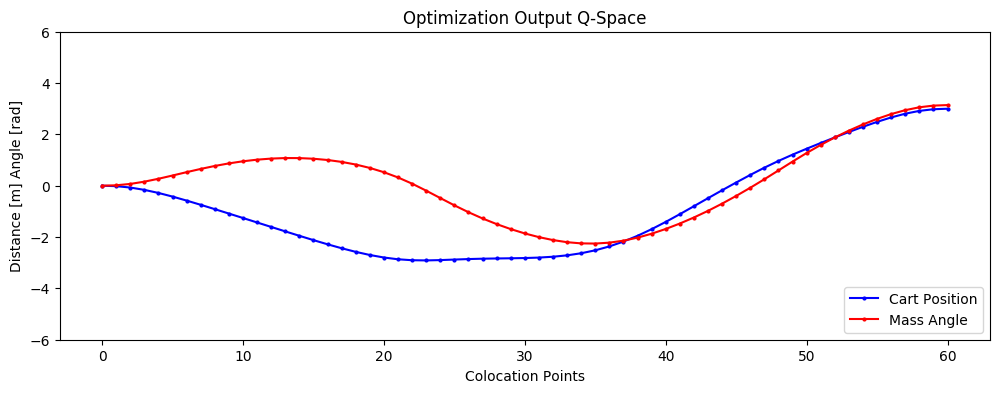

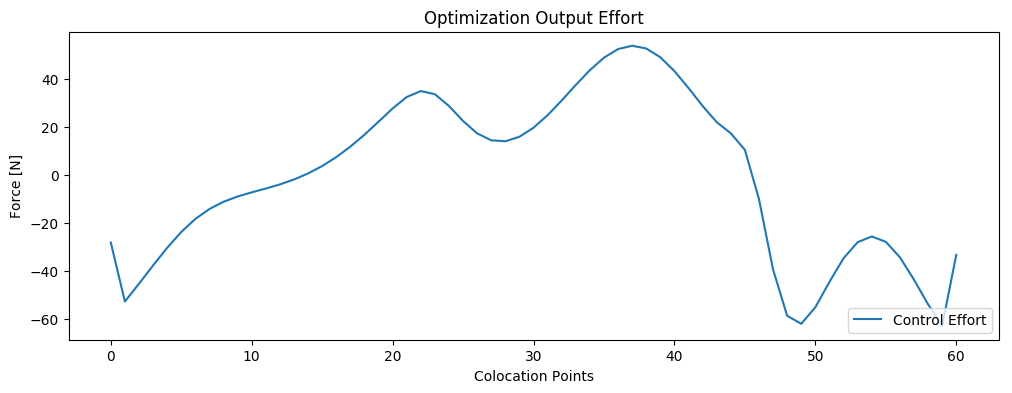

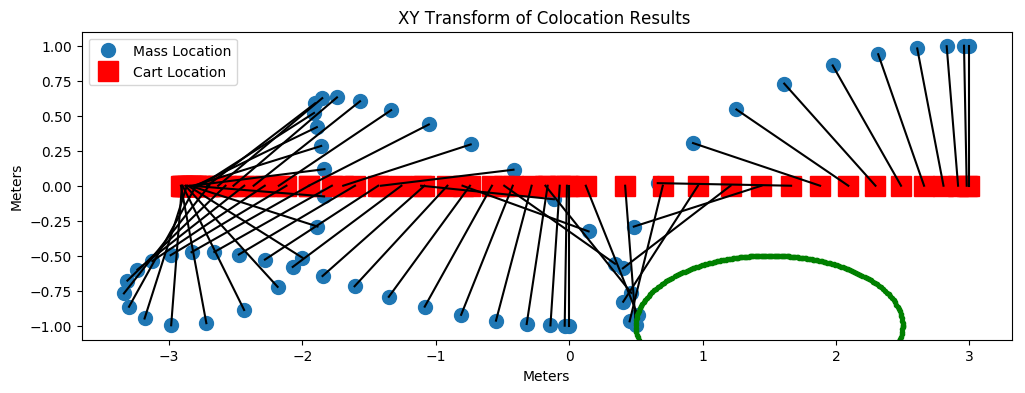

In [93]:
# Elipse Constarint Paramaters
a = 1
b = 0.5
c = 1
xoff = 1.5
yoff = -1

(m, c, x, xdot, xCordM, yCordM, xCordC, yCordC) = SolvFullCartPullObstical(x0,xf,3,.05, a, b, c, xoff, yoff)

using PyPlot
figure(figsize=(12,4))
title("Optimization Output Q-Space")
xlabel("Colocation Points")
ylabel("Distance [m] Angle [rad]")
plot( x[1,:], "b.-", markersize = 4)
plot( x[2,:], "r.-", markersize = 4)
ylim([-6,6])
legend(["Cart Position","Mass Angle"], loc="lower right")

figure(figsize=(12,4))
title("Optimization Output Effort")
xlabel("Colocation Points")
ylabel("Force [N]")
plot(c[1,:])
legend(["Control Effort"], loc="lower right")

figure(figsize=(12,4))
title("XY Transform of Colocation Results ")
xlabel("Meters")
ylabel("Meters")
plot( xCordM, yCordM,".", markersize = 20)
plot( xCordC, yCordC,"rs", markersize = 15)
legend(["Mass Location","Cart Location"])
for i =1:length(xCordM)
 plot( [xCordM[i],xCordC[i]] , [yCordM[i], yCordC[i]],"k")
end
# Plotting Ellipse
angle = linspace(0,2*3.14595,360)
r = zeros(1,length(angle))
xE = zeros(1,length(angle))
yE = zeros(1,length(angle))
for i = 1:length(angle)
    r[i] = a*b/sqrt(b^2*cos(angle[i])^2 + a^2*sin(angle[i])^2)
    xE[i] = r[i]*cos(angle[i]) + xoff
    yE[i] = r[i]*sin(angle[i]) + yoff
end
plot(xE,yE,"g.--");
ylim([-1.1,1.1]);

# Placeholder for a GIF of the Simulation

The Q space optimization plot shows the carts position and the angle of the pendulum at each colocation point. As expected the cart and the pendulem ends up in the desired position. However, the optimal trajectory is achieved by reversing first allowing the cart more room to avoid the obstical. The effort plot shows the maximum cart force is needed at the point when the pendulum is being wipped to its virtical position. This result is consistant with the full dynamics used in this simulation.Finaly the XY transfom of colocation results shows how the pendulum is able to avoid the obstical plotted in green.

This method of object avoidance is usefull becasue it is fairly genaric, multiple constraints could be used and the generated trajectories closely match the real life dynamics of the system. However, nonlinear constraints add complexity to the model and increase solution times. For this solution to implemented properly an additional nonlinear constraint must be added for each colocation point, in this case 60 additional constraints per object.

below, I define a library function which will convert the kinematics from a minimal set of generalized coordinates, to the maximal set that is required for my 3d ploting function:

In [97]:
"""takes a 3x3 rotation matrix and converts it to a 4x1 array of euler parameters"""
function A2P(A::Array) 
  e0 = sqrt((trace(A) + 1)/4)
  if e0 != 0
    e1 = (A[3,2] - A[2,3])/(4*e0)
    e2 = (A[1,3] - A[3,1])/(4*e0)
    e3 = (A[2,1] - A[1,2])/(4*e0)
  end

  if e0 == 0  #implies Χ = π
    #figure out which e terms are non-zero
    e1flag = false; e2flag = false; e3flag = false;
    if A[1,1] + 1 != 0  e1flag = true end
    if A[2,2] + 1 != 0  e2flag = true end
    if A[3,3] + 1 != 0  e3flag = true end

    if e1flag
      e1 = sqrt((A[1,1] + 1)/2)
      e2 = (A[2,1] + A[1,2])/(4*e1)
      e3 = (A[3,1] + A[1,3])/(4*e1)
    elseif e2flag
      e2 = sqrt((A[2,2] + 1)/2)
      e1 = (A[2,1] + A[1,2])/(4*e2)
      e3 = (A[3,2] + A[2,3])/(4*e2)
    elseif e3flag
      e3 = sqrt((A[3,3] + 1)/2)
      e1 = (A[3,1] + A[1,3])/(4*e3)
      e2 = (A[3,2] + A[2,3])/(4*e3)
    else
      warn("something is wrong with A value  $A ")
    end
  end

  p = [e0 e1 e2 e3]'
end

#principle rotations
Rx(Θ) = [1 0 0 ; 0 cos(Θ) -sin(Θ) ; 0 sin(Θ) cos(Θ)]
Ry(Θ) = [ cos(Θ) 0 sin(Θ) ; 0 1 0 ; -sin(Θ) 0 cos(Θ)]
Rz(Θ) = [ cos(Θ) -sin(Θ) 0 ; sin(Θ) cos(Θ) 0  ; 0 0 1]


Rz (generic function with 1 method)

In [130]:
using DataFrames
"""
convert state vector x for the cart pull problem from a minimal set of generalized coordinates to a
maximal set of cartesian coordinates using euler parameters to describe rotation. additionally, 
rotations will be made so that things look right in unity

inputs:
    x - state vector resulting from from our control optimization
    fln - string of file location
outputs:
    csv - write a csv to the proper location
    
assumptions:
-This code assumes the original simulation is resampled at 30Hz so the visualization timing is correct
- left handed coordinates as defined in unity:
    * y is up
    * x is left
    * z is out of the page

movement of the cart occures along the x, and rotation of the pendulum occures about z axis
"""
function process2CSV(x,path = "./pullCartVis3D/Assets/Data/data.csv")
    
    #extract state, we only need q1 and q2
    x = x[1:2,:]
    
    #build out fill state matrix  xFull = [r₁;r₂;p₁;p₂]
    nb = 2;
    xFull = zeros(7*nb, size(x)[2])  
    
    #place location parameters appropriately
    xFull[1,:] = x[1,:]
    xFull[4,:] = x[1,:]
    xFull[6,:] = .15*ones(size(x)[2],1)                 #unity compensation
    
    #place orientation parameters appropriately
    for i in range(1,size(x)[2])  
        xFull[7:10,i]   = A2P(Rx(pi/2)*eye(3))          #unity compensation
        xFull[11:14,i] = A2P(Rx(pi/2)*Ry(x[2,i]))       #unity compensation
    end
        
    #print to CSV
    xFull = convert(DataFrame, xFull)
    writetable(path,xFull)
end
    

#future:
"""
upsample or downsample 
"""
function resamplex(x,freq = 100);
    
    


process2CSV

In [131]:
process2CSV(x)

notes:

**what we have working:**
* a forward euler based solver with highly linearized dynamics, that is capable of solving 
    - optimal control of a non-inverted pendulum
    - optimal control of a swing up problem. 
    
* a unity visualizer that will display any movement of the pendulum, when given an input vector x


**Things we still need to do:**
- a proper introduction to for all these sections...
- this includes a proper derivation of the dynamics of the cart pull system
- explore what happens if we put simple path constraints on the existing system
- implement full direct collocation (with backwards euler / trapozoid method) 

**our modeling framework: levels of complexity and assumptions - each assumption removes a level of complexity in the dynamics**    
1. assumptions - small angles and quazi-static
   model - quadratic objective with Linear constraints (this is what we have working)
2. assumptions - small angles
   model - quadratic objective with quadratic constraints(to be implemented) - should solve with gurobi
3. no assumptions - full dynamics 
   model - quadratic objective with non-linear constraints - NLP - requires IPOPT library to solve


**order of integration method**
0. zero order
1. 1st order (trapezoid)
2. 2nd order or higher (math gets pretty intense)


**Implement a numerical solver to solve the system as an IVP** - I think that using a numerical solver to take the u(t) calculated by the method and then forward integrating it with the Real dynamics would be an interesting way to assess how bad each of the assumptions actually impacts the performance of this simple system. 
        
        
        
**Things we could do:**
    *explore simpsons-hermite transcription (higher order method than trapozoid)
    *explore the effect of ZOH, since this is what is actually possible as a control signal
    *explore exotic path constraints (swing up, but avoid these obsticles while you go through
    *alternative objective, robust control

    

**proposed organization of report:**

* Introduction
```julia
for model in increasing complexity```
    * Mathematical Model
    * Solution
    * Results / discussion
```julia
end```
* Conclusion
